<a href="https://colab.research.google.com/github/mrcruz117/Prophet-Parameter-Tuning-Dev/blob/main/Prophet_Parameter_Tuning_Dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prophet - Parameter Tuning
- dev env

In [2]:
#change directory
%cd /content/drive/MyDrive/Time Series Forecasting Product

/content/drive/MyDrive/Time Series Forecasting Product


In [3]:
#libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
#load the data
#YYYY-MM-DD
df = pd.read_csv('nyc_data.csv')
df.head()

,Date,Demand,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,1/1/2015,720.000885,0,0,0,3.68,41.305
1,1/2/2015,581.276773,0,0,0,4.73,131.574
2,1/3/2015,754.117039,0,0,0,7.23,162.700
3,1/4/2015,622.252774,0,0,0,10.96,160.281
4,1/5/2015,785.373319,0,0,0,6.92,51.077


In [5]:
#Rename variable
df = df.rename(columns = {'Demand': 'y', 'Date' : 'ds'})
df.head(0)

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing


In [7]:
# Transforming Date: YYY-MM-DD
df.ds = pd.to_datetime(df.ds, format = '%m/%d/%Y')

In [8]:
df.head()

,ds,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
0,2015-01-01,720.000885,0,0,0,3.68,41.305
1,2015-01-02,581.276773,0,0,0,4.73,131.574
2,2015-01-03,754.117039,0,0,0,7.23,162.700
3,2015-01-04,622.252774,0,0,0,10.96,160.281
4,2015-01-05,785.373319,0,0,0,6.92,51.077


## Holidays

In [10]:
# Easter
dates = df[df.Easter == 1].ds
easter = pd.DataFrame({
    'holiday': 'easter',
    'ds': dates,
    'lower_window': -5,
    'upper_window': 2,
})

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2
1928,easter,2020-04-12,-5,2


In [14]:
# Thanksgiving
dates = df[df.Thanksgiving == 1].ds
thanksgiving = pd.DataFrame({
    'holiday': 'thanksgiving',
    'ds': dates,
    'lower_window': -3,
    'upper_window': 5,
})
# Christmas
dates = df[df.Christmas == 1].ds
christmas = pd.DataFrame({
    'holiday': 'christmas',
    'ds': dates,
    'lower_window': -7,
    'upper_window': 7,
})

In [16]:
# combine all events
holidays = pd.concat([easter, thanksgiving, christmas])

holidays.head(5)

,holiday,ds,lower_window,upper_window
94,easter,2015-04-05,-5,2
451,easter,2016-03-27,-5,2
836,easter,2017-04-16,-5,2
1186,easter,2018-04-01,-5,2
1571,easter,2019-04-21,-5,2


In [18]:
# drop old holidays cols
df_final = df.drop(columns = ['Easter', 'Thanksgiving', 'Christmas'])
df_final.head()

,ds,y,Temperature,Marketing
0,2015-01-01,720.000885,3.68,41.305
1,2015-01-02,581.276773,4.73,131.574
2,2015-01-03,754.117039,7.23,162.700
3,2015-01-04,622.252774,10.96,160.281
4,2015-01-05,785.373319,6.92,51.077


## Parameters
- key parameters
  - **seasonality**: yearly, weekly, daily, etc
  - **seasonality mode**: multiplicative or additive
  - **holidays**
  - **seasonality_prior_scale**: strength of seasonality
  - **holiday_prior_scale**: how much do holidays interfere with the normal seasonal fluxuations
  - **changepoint_prior_scale**: how sensitive is the trendline to changes


## Prophet Model

In [19]:
from prophet import Prophet

In [20]:
# building the model
m = Prophet(
    holidays=holidays,
    seasonality_mode='multiplicative',
    seasonality_prior_scale=10,
    holidays_prior_scale=10,
    changepoint_prior_scale=0.05
)
m.add_regressor("Temperature")
m.add_regressor("Marketing")
# fit model
m.fit(df_final)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/4pruoz4_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/ugiz_irw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29077', 'data', 'file=/tmp/tmpt68t3stb/4pruoz4_.json', 'init=/tmp/tmpt68t3stb/ugiz_irw.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model_97cmjxq/prophet_model-20250218160101.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:01:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
16:01:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


## Cross-Validation

In [21]:
from prophet.diagnostics import cross_validation

In [22]:
# how many days in dataset?
df.shape[0] - 180

2012

In [24]:
df_cv = cross_validation(
    model = m,
    horizon = '31 days',
    period = '16 days',
    initial = '2012 days',
    parallel = 'processes'
)

INFO:prophet:Making 10 forecasts with cutoffs between 2020-07-09 00:00:00 and 2020-11-30 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f47fe042790>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/d59efsds.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/3jd6kczd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/u0j4oscj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8719', 'data', 'file=/tmp/tmpt68t3stb/3jd6kczd.json', 'init=/tmp/tmpt68t3stb/u0j4oscj.json', 'output', 'file=/tmp/tmpt68t3stb/prophet_model1l7k18tv/prophet_model-20250218161253.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
16:12:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpt68t3stb/uk6aqewx.json
DEB

In [25]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-07-10,607.600343,544.459413,671.078133,571.069531,2020-07-09
1,2020-07-11,722.756372,660.321752,787.473295,677.106981,2020-07-09
2,2020-07-12,637.709391,570.836068,703.685297,619.572774,2020-07-09
3,2020-07-13,769.901813,702.107724,834.060916,808.932621,2020-07-09
4,2020-07-14,637.317035,568.345514,702.603963,661.791644,2020-07-09


Prophet comes with helpful functions to test performance

In [37]:
# performance metrics
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [29]:
metrics = performance_metrics(df_cv)
metrics.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,2816.526046,53.070953,43.585827,0.059121,0.060690,0.060220,0.800000
1,5 days,2798.611929,52.901909,44.378974,0.062103,0.062914,0.062893,0.767742
2,6 days,3493.372151,59.104756,50.206298,0.069428,0.062736,0.070839,0.703226
3,7 days,2784.063423,52.764225,42.607514,0.060086,0.059503,0.061128,0.703226
4,8 days,2718.948136,52.143534,40.120799,0.055470,0.058671,0.056952,0.732258


In [36]:
rmse = round(performance_metrics(df_cv)['rmse'].mean(), 1)
mape = round(performance_metrics(df_cv)['mape'].mean() * 100, 3)

print(f"RMSE: {rmse}")
print(f"Mape: {mape}")

RMSE: 54.1
Mape: 5.864


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


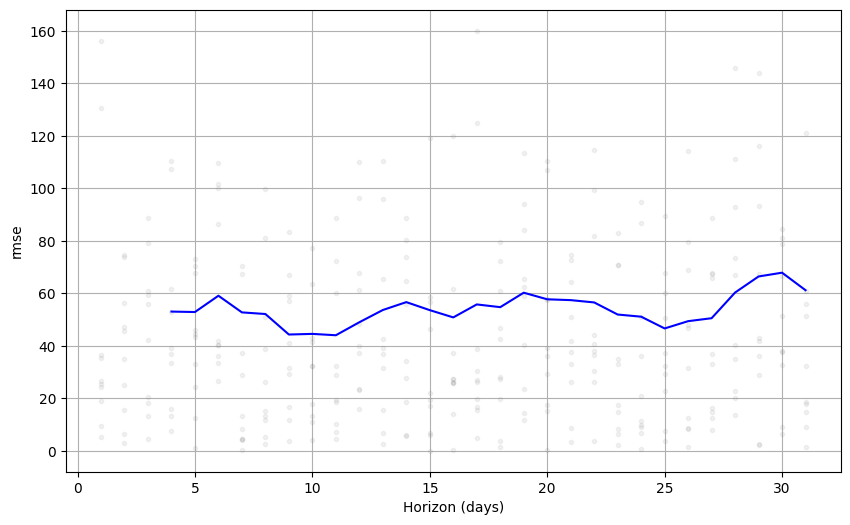

In [40]:
# plotting performance metrics overtime
plot_cross_validation_metric(
    df_cv,
    metric='rmse'
);
# error overtime